In [224]:
import os
import re
import pandas as pd

## Příprava dat

In [226]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

In [227]:
df = pd.read_parquet(os.path.join("data","cnb_ceska_proza.parquet"))
len(df)

47902

In [228]:
df = df.merge(pd.read_parquet(os.path.join("data","cnb_vyber.parquet")), left_index=True, right_index=True, how='inner')

In [229]:
len(df)

44251

In [230]:
df = df[df['rok'] >= 2019]

In [231]:
graf_rok_min = int(df['rok'].min())
graf_rok_min

2019

In [232]:
graf_rok_max = int(df['rok'].max())
graf_rok_max

2025

In [233]:
len(df)

8325

In [234]:
df = df.explode('020_a')

In [235]:
def isbn(x):
    try:
        if len(x.replace('-','')) == 13:
            return str(x.replace('-',''))
    except:
        pass

In [236]:
df['isbn'] = df['020_a'].apply(lambda x: isbn(x))

In [237]:
df[['020_a','isbn']].sample(20)

,020_a,isbn
001,,
nkc20243614591,978-80-7497-489-2,9788074974892
nkc20233533574,978-80-242-9414-8,9788024294148
nkc20223467488,978-80-264-4482-4,9788026444824
nkc20213311092,978-80-7633-224-9,9788076332249
nkc20203257534,978-80-257-3282-3,9788025732823
nkc20233555744,978-80-7612-587-2,9788076125872
nkc20223465157,978-80-88067-64-1,9788088067641
nkc20233549139,978-80-264-4886-0,9788026448860
nkc20203238029,978-80-88343-08-0,9788088343080


In [238]:
odkud = "data_raw/ebooky"

In [239]:
stazene = set([x.split(".")[0] for x in os.listdir(odkud)])
len(stazene)

2898

In [240]:
df = df[df['isbn'].isin(stazene)]

In [241]:
df

,rok,titul,autorstvo,autorstvo_kod,008,020_a,020_c,020_q,041_a,041_h,041_ind1,044_a,072_a,072_x,080_a,100_4,100_7,100_a,100_d,240_l,245_a,245_c,245_n,245_p,246_a,250_a,250_b,260_a,260_b,260_c,260_e,260_f,260_ind1,264_a,264_b,264_c,264_ind2,300_a,300_b,300_c,490_a,490_v,500_a,521_a,546_a,648_a,650_a,650_x,650_y,650_z,651_a,653_a,655_a,700_4,700_7,700_a,700_d,710_4,710_7,710_a,710_b,830_a,928_a,964_a,leader,isbn
001,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
nkc20193162052,2019.0,Čarodějnice,Vostrý Mirek,mzk2018995176,200120s2019 xr g 000 j cze,978-80-88318-05-7,None,[(brožováno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-32, (0:82-32)]",[aut],mzk2018995176,"Vostrý, Mirek,",1968-,None,Čarodějnice /,Mirek Vostrý,None,None,None,[Vydání první],None,None,None,None,None,None,None,[Brandýs n/L :],"[Tofana,]",[2019],[1],[187 stran ;],None,[19 cm],None,None,[150 výtisků],None,None,None,None,None,None,None,None,None,"[české povídky, Czech short stories]",None,None,None,None,None,None,None,None,None,None,None,nam a22 i 4500,9788088318057
nkc20193162055,2019.0,Ke Gogolovi a zpátky,Rollingerová-Riba Romana,jo20000075610,191127s2019 xr g 000 f cze,978-80-7487-279-2,"[Kč 299,00]",[(brožováno) :],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-31)]",[aut],jo20000075610,"Rollingerová-Riba, Romana,",1971-,None,Ke Gogolovi a zpátky /,Romana Riba-Rollingerová,None,None,None,[Vydání první],None,None,None,None,None,None,None,[V Brumovicích :],"[Carpe diem,]",[2019],[1],[267 stran ;],None,[19 cm],None,None,None,None,None,None,None,None,None,None,None,None,"[české romány, Czech fiction]",None,None,None,None,None,None,None,None,None,None,None,nam a22 i 4500,9788074872792
nkc20193161777,2019.0,Dobře zašitej frajer,Šabach Petr,jn19990201046,191211s2019 xr g 000 j cze,978-80-7637-070-8,"[Kč 399,00]",[(vázáno) :],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-32, (0:82-32), (082.21)]",[aut],jn19990201046,"Šabach, Petr,",1951-2017,None,Dobře zašitej frajer /,to nejlepší z Petra Šabacha uspořádali Emil Ha...,None,None,None,[Vydání první],None,None,None,None,None,None,None,[V Praze :],"[Paseka,]",[2019],[1],[333 stran ;],None,[23 cm],None,None,"[Údaj o vydání je chybný, správně má být: Vydá...",None,None,None,None,None,None,None,None,None,"[české povídky, české novely, výbory, Czech sh...","[edt, edt]","[jn20000400849, jn19990209335]","[Hakl, Emil,, Kahuda, Václav,]","[1958-, 1965-2023]",None,None,None,None,None,None,None,nam a22 i 4500,9788076370708
nkc20193158977,2019.0,Ukradená vražda,Češka Stanislav,xx0122614,191111s2019 xr g 000 f cze d,978-80-243-8914-1,None,[(vázáno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-312.4)]",[aut],xx0122614,"Češka, Stanislav,",1955-,None,Ukradená vražda :,Stanislav Češka,None,None,None,[Vydání první],None,None,None,None,None,None,None,[Brno :],"[MOBA,]",[2019],[1],[252 stran ;],None,[19 cm],"[Původní česká detektivka ;, Krimi]","[313. svazek, None]",None,None,None,None,None,None,None,None,None,None,"[české romány, detektivní romány, Czech fictio...",None,None,None,None,None,None,None,None,"[Původní česká detektivka, Krimi (MOBA)]",None,None,nam a22 i 4500,9788024389141
nkc20193158538,2019.0,Bezejmenní,Krčmář Milan,jo2012727454,191111s2019 xr h g 000 f cze,978-80-264-2789-6,"[Kč 449,00]","[(CPress ;, vázáno) :]",None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (=411.16), 314.151.3-054.73, 34...",[aut],jo2012727454,"Krčmář, Milan",None,None,Bezejmenní :,Milan Krčmář,None,None,None,[1. vydání],None,None,None,None,None,None,None,[V Brně :],"[CPress,]",[2019],[1],[479 stran :],[faksimile ;],[24 cm],None,None,"[V tiráži uvedeno nakladatelství: Edika, Termi...",None,None,"[1921-1930, 20. století, 1925]","[Židé, uprchlíci, vraždy, soudní procesy, Jews...",None,"[20. století, 20. století, 20. století, 1921-1...","[Polsko, Polsko, Česko, Česko, Poland, Poland,...","[Třebíč (Česko), Třebíč (Czechia)]",None,"[české román

In [242]:
autority = pd.read_parquet(os.path.join("data","aut_vyber.parquet"))

In [243]:
autority = autority.merge(pd.read_parquet(os.path.join('data','wikidata.parquet')), left_index=True, right_index=True, how="outer")

In [244]:
autority.sample(5)

,024_2,024_a_x,046_f,046_g,100_7,100_a,100_d,100_ind1,110_a,370_a,370_b,370_c,370_f,372_a,373_a,374_a,375_a,377_a,400_a,400_d,400_i,400_ind1,410_a,411_a,430_a,450_a,500_a,500_i,500_ind1,550_7,678_a,856_u,leader,024_a_y,ceny,druh_umrti,facebook,instagram,jazykove_verze,label_cs,label_en,manzelstvo,obcanstvi,partnerstvo,popis_cs,popis_en,potomstvo,pricina_umrti,profese,role,skoly,sourozenectvo,strany,twitter,udalosti,vezeni,w_gender,w_misto_narozeni,w_misto_umrti,w_narozeni,w_narozeni_presne,w_umrti,w_umrti_presne,web,wiki_cs,wiki_en
xx0159208,None,None,[1903],[1984],[xx0159208],"[Hentzen, Alfred,]",[1903-1984],[1],None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[Německý kunsthistorik. autor publikací z oboru.],[http://de.wikipedia.org/wiki/Alfred_Hentzen],cz a22 n 4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xx0268677,None,None,[1939],[2021],[xx0268677],"[Erdtmann, Bernd-Dietrich,]",[1939-2021],[1],None,None,None,None,None,[paleontologie],"[Západočeské muzeum (Plzeň, Česko)]","[paleontologové, vysokoškolští učitelé, sběrat...",[muž],None,None,None,None,None,None,None,None,None,None,None,None,None,"[Německý paleontolog, vysokoškolský pedagog v ...",None,nz a22 n 4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kn20110808008,None,None,None,None,None,None,None,None,None,None,None,[Česko],None,None,None,None,None,None,None,None,None,None,None,"[Máchovské sympozium, Máchovské sympozium - mo...",None,None,None,None,None,None,None,None,cz a22 n 4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
osa2017952362,None,None,[1971],None,[osa2017952362],"[Dreher, Jan,]",[1971-],[1],None,"[Bonn, Německo]",None,[Německo],"[Krefeld, Německo]","[psychoterapie, psychiatrie]",None,"[psychoterapeuti, psychiatři]",[muž],[ger],None,None,None,None,None,None,None,None,None,None,None,None,[Německý lékař - psychiatr a psychoterapeut. P...,None,nz a22 n 4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pna2016933638,None,None,None,None,None,None,None,None,"[Boxing Club Star (Plzeň, Česko)]",None,None,[Česko],None,"[box, úpolové sporty]",None,None,None,[cze],None,None,None,None,"[BC Star (Plzeň, Česko)]",None,None,None,None,None,None,None,None,None,nz a22 n 4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [245]:
autority.columns

Index(['024_2', '024_a_x', '046_f', '046_g', '100_7', '100_a', '100_d',
       '100_ind1', '110_a', '370_a', '370_b', '370_c', '370_f', '372_a',
       '373_a', '374_a', '375_a', '377_a', '400_a', '400_d', '400_i',
       '400_ind1', '410_a', '411_a', '430_a', '450_a', '500_a', '500_i',
       '500_ind1', '550_7', '678_a', '856_u', 'leader', '024_a_y', 'ceny',
       'druh_umrti', 'facebook', 'instagram', 'jazykove_verze', 'label_cs',
       'label_en', 'manzelstvo', 'obcanstvi', 'partnerstvo', 'popis_cs',
       'popis_en', 'potomstvo', 'pricina_umrti', 'profese', 'role', 'skoly',
       'sourozenectvo', 'strany', 'twitter', 'udalosti', 'vezeni', 'w_gender',
       'w_misto_narozeni', 'w_misto_umrti', 'w_narozeni', 'w_narozeni_presne',
       'w_umrti', 'w_umrti_presne', 'web', 'wiki_cs', 'wiki_en'],
      dtype='object')

In [246]:
df = df.merge(autority[['w_gender','w_umrti','046_g','375_a']], left_on="autorstvo_kod", right_index=True, how="left")

In [247]:
df = df[(df['w_umrti'].isnull()) | (df['046_g'].isnull())]

In [248]:
df.sample(5)

,rok,titul,autorstvo,autorstvo_kod,008,020_a,020_c,020_q,041_a,041_h,041_ind1,044_a,072_a,072_x,080_a,100_4,100_7,100_a,100_d,240_l,245_a,245_c,245_n,245_p,246_a,250_a,250_b,260_a,260_b,260_c,260_e,260_f,260_ind1,264_a,264_b,264_c,264_ind2,300_a,300_b,300_c,490_a,490_v,500_a,521_a,546_a,648_a,650_a,650_x,650_y,650_z,651_a,653_a,655_a,700_4,700_7,700_a,700_d,710_4,710_7,710_a,710_b,830_a,928_a,964_a,leader,isbn,w_gender,w_umrti,046_g,375_a
001,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
nkc20223466916,2022.0,Křídla vážky,Dopitová Michaela,xx0278101,221026s2022 xr d 000 f cze,978-80-253-6051-4,"[Kč 349,00]",[(brožováno) :],None,None,None,None,"[821.162.3-3, 821-93]","[Česká próza, Literatura pro děti a mládež (be...","[821.162.3-31, 821-93, (0:82-31)-055.25]",[aut],xx0278101,"Dopitová, Michaela,",1998-,None,Křídla vážky /,Michaela Dopitová,None,None,None,[1. vydání],None,None,None,None,None,None,None,[V Praze :],"[Fragment,]",[2022],[1],[236 stran ;],None,[21 cm],None,None,None,None,None,None,None,None,None,None,None,None,"[české romány, dívčí romány, publikace pro mlá...",None,None,None,None,None,None,None,None,None,[Albatros Media - Fragment],None,nam a22 i 4500,9788025360514,žena,NaN,None,[žena]
nkc20213312935,2021.0,Slyšet jeleny zpívat,Šmehlík František,mzk2016899680,210317s2021 xr g 000 f cze d,978-80-257-3461-2,"[Kč 398,00]",[(vázáno) :],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-312.4)]",[aut],mzk2016899680,"Šmehlík, František,",1995-,None,Slyšet jeleny zpívat /,František Šmehlík,None,None,None,[První vydání],None,None,None,None,None,None,None,[Praha :],"[Argo,]",[2021],[1],[324 stran ;],None,[21 cm],None,None,[Obálkový podnázev: detektivní román z Beskyd],None,None,None,None,None,None,None,None,None,"[české romány, detektivní romány, Czech fictio...",None,None,None,None,None,None,None,None,None,None,None,cam a22 i 4500,9788025734612,muž,NaN,None,[muž]
nkc20203182088,2020.0,Underground,Kotleta František,xx0123480,200324s2020 xr g 000 f cze,978-80-7557-241-7,"[Kč 299,00]",[(brožováno) :],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-311.9)]",[aut],xx0123480,"Kotleta, František",1981-,None,Underground /,František Kotleta,None,None,None,[První vydání],None,None,None,None,None,None,None,[Praha :],"[Epocha s.r.o.,]",[2020],[1],[300 stran ;],None,[18 cm],[Fantastická Epocha],None,None,None,[Český text],None,None,None,None,None,None,None,"[české romány, vědecko-fantastické romány, Cze...",None,None,None,None,None,None,None,None,[Fantastická Epocha],None,None,nam a22 i 4500,9788075572417,muž,NaN,None,[muž]
nkc20223417684,2022.0,Záhada zmizelého šlechtice,Novotná Martina,xx0257330,221004s2022 xr g 000 f cze d,978-80-279-0466-2,None,[(vázáno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-312.4), (0:82-311.6)]",[aut],xx0257330,"Novotná, Martina,",1983-,None,Záhada zmizelého šlechtice /,Martina Novotná,None,None,None,[Vydání první],None,None,None,None,None,None,None,[Brno :],"[MOBA,]",[2022],[1],[344 stran ;],None,[21 cm],None,None,None,None,None,None,None,None,None,None,None,None,"[české romány, detektivní romány, historické r...",None,None,None,None,None,None,None,None,None,None,None,cam a22 i 4500,9788027904662,žena,NaN,None,[žena]
nkc20203171205,2020.0,Odříkaného manžela největší krajíc,Jakoubková Alena,mzk2002102588,200120s2020 xr g 000 f cze d,978-80-243-9170-0,None,[(vázáno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-31)-055.2]",[aut],mzk2002102588,"Jakoubková, Alena,",1958-,None,Odříkaného manžela největší krajíc /,Alena Jakoubková,None,None,None,[Vydání první],None,None,None,None,None,None,None,[Brno :],"[MOBA,]",[2020],[1],[268 stran ;],None,[21 cm],None,None,None,None,None,None,None,None,None,None,None,None,"[české romány, romány pro ženy, Czech fiction,...",None,None,None,None,None,None,None,None,None,None,None,cam a22 i 4500,9788024391700,žena,NaN,None,[žena]


In [249]:
len(df)

1311

In [250]:
len(df[df['w_gender'].notnull()])

1110

In [251]:
def tri_gendery(trisedmpeta, gender_wikidata, autors):
    z = None
    if (str(autors).split(" ")[0][-1] == 'á'):
        z = 'á'
    else:
        z = 'neá'
    if gender_wikidata in (['muž','žena']):
        z = gender_wikidata
    try:
        for y in trisedmpeta:
            z = y
    except:
        pass
    return z

In [252]:
df['gender'] = df.apply(lambda row: tri_gendery(row['375_a'],row['w_gender'],row['autorstvo']), axis=1)

In [253]:
df[['autorstvo','w_gender','375_a','gender']]

,autorstvo,w_gender,375_a,gender
001,,,,
nkc20193162052,Vostrý Mirek,muž,[muž],muž
nkc20193162055,Rollingerová-Riba Romana,žena,None,žena
nkc20193158977,Češka Stanislav,muž,[muž],muž
nkc20193158538,Krčmář Milan,muž,None,muž
nkc20193158828,Vondruška Vlastimil,muž,[muž],muž
...,...,...,...,...
nkc20243606974,Jakoubková Alena,žena,[žena],žena
nkc20243606884,Rývorová Alžběta,NaN,[žena],žena
nkc20243607639,Sekerka Tomáš,muž,[muž],muž


In [254]:
df[df['gender'].isnull()][['autorstvo','w_gender','375_a','gender']]

,autorstvo,w_gender,375_a,gender
001,,,,


## Příprava knih

In [256]:
import simplemma

In [257]:
def remove_non_letters(input_string):
        # Define an empty string to store our result
        result_string = ''

        # Loop through each character in the given string
        for character in input_string:
            # If the character is a letter or whitespace
            if character.isalpha() or character.isspace():
                # Include it in our result string
                result_string += character

        # Return the cleaned string
        return result_string

In [258]:
ukazky = []
for i in df[df['gender'].notnull()]['isbn'].to_list():
    ukazka = {}
    ukazka['isbn'] = i
    with open(os.path.join(odkud, f"{i}.txt"), 'r', encoding='utf-8') as u:
        text = remove_non_letters(u.read().lower().strip().replace('\n',' ').replace('\t','').replace('\xa0',' '))
        slova = []
        ukazka['rozsah'] = len(text)
        for t in [t for t in text.split(' ') if len(t) > 2]:
            slova.append(simplemma.lemmatize(t, lang='cs'))
        ukazka['slova'] = set(slova)
        if len(set(slova)) > 50:
            ukazky.append(ukazka)

In [259]:
mz = pd.DataFrame(ukazky)
mz.sample(5)

,isbn,rozsah,slova
862,9788025741429,140273,"{starost, uklouzl, ach, šestý, dařit, pobavený..."
0,9788088318057,18416,"{naděje, minimálně, kufříku, apolenu, bloudit,..."
127,9788025349212,12990,"{některý, najít, šestý, zakroutil, jmenovat, h..."
41,9788075973368,25970,"{smržů, některý, bezpodmínečně, nutkáním, faku..."
275,9788027502417,30337,"{některý, starost, zkracovat, svírat, monarchi..."


In [260]:
mz = mz.merge(df[['isbn','gender','autorstvo_kod']], left_on='isbn', right_on='isbn', how='left')

In [261]:
mz

,isbn,rozsah,slova,gender,autorstvo_kod
0,9788088318057,18416,"{naděje, minimálně, kufříku, apolenu, bloudit,...",muž,mzk2018995176
1,9788074872792,20802,"{bradka, náhradník, maturitě, následující, fak...",žena,jo20000075610
2,9788024389141,16962,"{dlouholetý, členka, minimálně, konzultace, st...",muž,xx0122614
3,9788026427896,110563,"{některý, rentgenování, starost, berle, šestý,...",muž,jo2012727454
4,9788024389059,20745,"{starost, ostatní, soutic, dluh, spočítat, šaf...",muž,xx0004129
...,...,...,...,...,...
1277,9788075886170,16377,"{některý, starost, lekce, marketér, rostlo, ha...",muž,jk01082907
1278,9788076951822,33056,"{některý, starost, bloudit, barceloně, svírat,...",muž,jo2006362253
1279,9788027913282,24751,"{některý, starost, popřát, kytice, ach, ostatn...",žena,mzk2002102588
1280,9788075886217,50270,"{některý, berle, kněz, ochably, ostatní, dařit...",muž,xx0251298


## Základní statistiky

In [263]:
len(mz[mz['gender'] == 'muž'])

571

In [264]:
mz[mz['gender'] == 'muž']['autorstvo_kod'].nunique()

348

In [265]:
len(mz[mz['gender'] == 'žena'])

667

In [266]:
mz[mz['gender'] == 'žena']['autorstvo_kod'].nunique()

420

In [267]:
mz = mz.drop_duplicates(subset=['autorstvo_kod'], keep="last")

Rozsah zkoumaného textu v NS:

In [269]:
mz['rozsah'].sum() / 1800

12463.03

In [270]:
graf_rozsah = int((mz['rozsah'].sum() / 1800 / 1000).round())
graf_rozsah

12

In [271]:
graf_muzi = mz[mz['gender'] == 'muž']['autorstvo_kod'].nunique()
graf_muzi

348

In [272]:
graf_zeny = mz[mz['gender'] == 'žena']['autorstvo_kod'].nunique()
graf_zeny

420

Velikost vzorku celkem:

In [274]:
mz[mz['gender'] == 'muž']['autorstvo_kod'].nunique() +mz[mz['gender'] == 'žena']['autorstvo_kod'].nunique()

768

In [275]:
mz_slova = mz.explode('slova')

In [276]:
kolik = mz_slova.groupby("slova").size()

In [277]:
kolik.quantile([0.01, 0.02, 0.1, 0.5, 0.75, 0.9, 0.99, 0.999])

0.010      1.000
0.020      1.000
0.100      1.000
0.500      1.000
0.750      3.000
0.900     10.000
0.990    152.000
0.999    617.624
dtype: float64

In [278]:
kolik

slova
Abraham      4
Abrahám      4
Achilles     1
Adam        61
Adamec       2
            ..
שקרן         1
 září        1
  pátek      1
 který       1
 patro       1
Length: 152345, dtype: int64

In [279]:
hranice = int(kolik.quantile(0.97))
hranice

49

In [280]:
mz_vyfiltrovana = kolik[kolik >= hranice].index.to_list()

In [281]:
mz_filtr = mz_slova[mz_slova['slova'].isin(mz_vyfiltrovana)]

In [282]:
z = mz_filtr[mz_filtr['gender'] == 'žena'].groupby('slova').size().reindex(mz_vyfiltrovana).fillna(1) / mz_filtr[mz_filtr['gender'] == 'žena']['isbn'].nunique()

In [283]:
m = mz_filtr[mz_filtr['gender'] == 'muž'].groupby('slova').size().reindex(mz_vyfiltrovana).fillna(1) / mz_filtr[mz_filtr['gender'] == 'muž']['isbn'].nunique()

In [284]:
pomer = m / z

In [285]:
pomer.sample(10)

slova
šeptat       0.883621
salát        0.317604
známá        0.864399
menší        1.156609
odevzdaň     0.817575
revoluce     1.896552
zpětný       0.885057
vyhrkla      0.385180
výchova      0.673617
zastřelit    1.156609
dtype: float64

## Všechna slova bez filtru

In [287]:
z2 = mz[mz['gender'] == 'žena'].explode('slova').groupby('slova').size() / mz_filtr[mz_filtr['gender'] == 'žena']['isbn'].nunique()
m2 = mz[mz['gender'] == 'muž'].explode('slova').groupby('slova').size() / mz_filtr[mz_filtr['gender'] == 'muž']['isbn'].nunique()

In [288]:
pomer_vsech = m2 / z2

In [289]:
pomer_vsech.dropna().sort_values().head(20)

slova
protočila      0.060345
sedávat        0.067050
davidovi       0.075431
převalovala    0.080460
upila          0.080460
nebolelo       0.086207
Gabriel        0.086207
stesk          0.086207
cpala          0.086207
nezeptala      0.086207
zamumlá        0.086207
zasměju        0.092838
hřebínek       0.092838
vstávala       0.092838
poskládaný     0.092838
dojíždět       0.092838
mělas          0.092838
otrávená       0.092838
uvázala        0.100575
uchechtne      0.100575
dtype: float64

In [290]:
pomer_vsech[pomer_vsech.index == 'erekce']

slova
erekce    9.655172
dtype: float64

In [291]:
pomer_vsech[pomer_vsech.index == 'sex']

slova
sex    0.900669
dtype: float64

In [292]:
pomer_vsech[pomer_vsech.index == 'porno']

slova
porno    2.931034
dtype: float64

In [293]:
pomer_vsech[pomer_vsech.index == 'vagína']

slova
vagína    1.810345
dtype: float64

In [294]:
pomer_vsech[pomer_vsech.index == 'penis']

slova
penis    1.064909
dtype: float64

In [295]:
pomer_vsech[pomer_vsech.index == 'fousy']

slova
fousy    1.810345
dtype: float64

In [296]:
pomer_vsech[pomer_vsech.index == 'chlup']

slova
chlup    0.553161
dtype: float64

In [297]:
pomer_vsech[pomer_vsech.index == 'nádor']

slova
nádor    1.609195
dtype: float64

In [298]:
pomer_vsech[pomer_vsech.index == 'fotbal']

slova
fotbal    1.787995
dtype: float64

In [299]:
pomer_vsech[pomer_vsech.index == 'hokej']

slova
hokej    1.475096
dtype: float64

In [300]:
pomer_vsech[pomer_vsech.index == 'rallye']

slova
rallye    1.206897
dtype: float64

In [301]:
pomer_vsech[pomer_vsech.index == 'Krkonoše']

slova
Krkonoše    0.938697
dtype: float64

In [302]:
pomer_vsech[pomer_vsech.index == 'Šumava']

slova
Šumava    1.206897
dtype: float64

In [303]:
pomer_vsech[pomer_vsech.index == 'Říp']

slova
Říp    1.206897
dtype: float64

## Celkový pohled

In [305]:
muzi = mz_filtr[mz_filtr['gender'] == 'muž']['autorstvo_kod'].to_list()
', '.join(sorted((df[df['autorstvo_kod'].isin(muzi)]['autorstvo'].drop_duplicates().to_list())))

'Ajvaz Michal, Balda David, Balák Libor, Banga Patrik, Bareš Pavel, Bauer Jan, Bazger Petr, Beran Ladislav, Beran Stanislav, Bernatský Vojtěch, Bečan Martin, Birdman Shigor, Blaho Ondřej, Boubín Dalibor, Boček Evžen, Boček Lukáš, Brož Petr, Budai David, Buddeus Ondřej, Bureš Roman, Bálek Jaroslav, Bárta Václav, Bílek Petr, Bým Petr, Březina Jiří, Březina Michal, Chadima Martin, Csicsely Lukáš, Ctibor Pavel, Cubeca Karel, Cílek Roman, Dadák Matěj, Decimus Erik, Denk Petr, Ditrych Břetislav, Diviš Aleš, Dobrylovský Jiří, Dobrý Marek, Dostál Aleš, Dotlačil Jakub, Doucha Josef, Dočekal Boris, Drbohlav Jan, Drescher Alex, Duda Jan, Dutka Edgar, Dvořák Marek, Dědič Jiří, Eidler Petr, Epstein Marek, Erml Richard, Fahrner Martin, Fanta Ondřej, Fibich Ondřej, Fišer Lukáš, Fišer Martin, Folný Jan, Fousek Josef, Fránek Jakub, Fuchs Oskar, Fíla Ivan, Galambica Ivan, Gardner Jan, Gdovín Vladimír Adam, Glockner David, Goffa Martin, Grant Jiří, Gravensteen A., Green Scum, Gris Daniel, Grmolec Zdeněk,

In [306]:
zeny = mz_filtr[mz_filtr['gender'] == 'žena']['autorstvo_kod'].drop_duplicates().to_list()
', '.join(sorted(df[df['autorstvo_kod'].isin(zeny)]['autorstvo'].drop_duplicates().to_list()))

'Abrahámová Martina, Addicks Lucie, Ambrožová Dorota, An Elen, Andrlová Šárka, Auzká Lucie, Aycox Klára, Babišová Martina, Bartošová Tereza, Basiková Anna, Basiková Bára, Baštanová Petra, Bechynková Lucie, Bellová Bianca, Bendová Karolína, Beranová Dana, Bernášková Jana, Blahová Miriam, Blanářová Alena, Blažková Kateřina, Bohatá Simona, Boho Michaela, Bolavá Anna, Bolfová Markéta, Borlová Julie, Boučková Martina, Boučková Tereza, Brabcová Kateřina, Braunová Petra, Brányiková Katarína, Bublanová Alžběta, Burgerová Kristýna, Bártová Anna Beatrix, Bílková Alžběta, Camille G, Chalupníková Kateřina, Chalupová Lenka, Chaya Lucie, Chlubnová Lenka, Cima Anna, Ciprová Oldřiška, Coufalová Valentýna, Czastková Klára, Damijo Alena, Dancingerová Marta, Denemarková Radka, Denková Melita, Devátá Ivanka, Divišová Anna, Dobiášová Tereza, Dobrovolná Ilona, Dolejšová Eva, Domská Marie, Donátová Uljana, Dopitová Michaela, Dostálová Zuzana, Dousková Irena, Drdlová Helena, Dubská Kateřina, Dusová Tereza, Du

In [307]:
len(pomer)

4580

<Axes: ylabel='Frequency'>

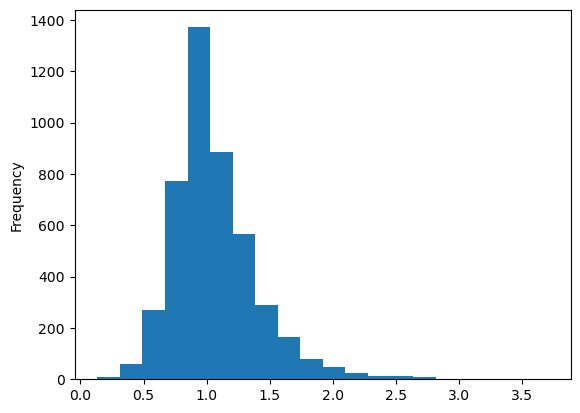

In [308]:
pomer.plot.hist(bins=20)

In [309]:
neutralita = pd.DataFrame(pomer).rename(columns={0:'cetnost'})
neutralita['odchylka'] = neutralita['cetnost'].apply(lambda x: x-1 if x>1 else 1-x)
neutralita.sort_values(by='odchylka').head(60)

,cetnost,odchylka
slova,,
jako,1.000000,0.000000
sousto,1.000000,0.000000
příjem,1.000000,0.000000
být,1.000000,0.000000
malej,1.000000,0.000000
div,1.000000,0.000000
foukat,1.000000,0.000000
když,1.000000,0.000000
ale,1.000000,0.000000


## Slova více používaná muži-spisovateli

In [311]:
pomer.sort_values(ascending=False).head(25)

slova
pistole          3.706897
prezident        3.469828
ruský            3.049002
kladivo          2.816092
vůl              2.790948
politik          2.775862
nepříliš         2.768763
velet            2.758621
kulka            2.735632
střílet          2.643678
zaregistrovat    2.640086
technický        2.633229
kapitán          2.629310
ohrozit          2.626775
smrtelný         2.614943
souboj           2.604356
západní          2.553050
zvláště          2.547893
vývoj            2.534483
vesta            2.484787
riziko           2.474138
civilizace       2.468652
isbn             2.460212
zápas            2.458493
motor            2.413793
dtype: float64

In [312]:
pomer[pomer.index.str.endswith('la')].sort_values()

slova
netušila         0.216970
zahlédla         0.244435
neuměla          0.260311
lekla            0.264929
nečekala         0.268199
užívala          0.288606
rozhlížela       0.301724
ucítila          0.310345
nestihla         0.333822
ptala            0.362069
četla            0.366802
vyhrkla          0.385180
přejela          0.388662
zadívala         0.389321
chystala         0.409483
chytla           0.429119
zkontrolovala    0.435824
nalila           0.441548
nešla            0.443350
nechávala        0.449078
ušklíbla         0.449628
strčila          0.452586
neřekla          0.454080
sklopila         0.464191
usmívala         0.465820
odložila         0.477730
mávla            0.510610
zamávala         0.517241
vzdychla         0.517241
zasmála          0.517241
vyrazila         0.534483
odvětila         0.578305
odsekla          0.588730
nepřišla         0.617482
zažila           0.636973
přikývla         0.658307
jezdila          0.689655
pohladila        0.715198
dokola

## Slova více používaná ženami-spisovatelkami

Pleso vypadá spíš jako špatné lemma slova ples.

In [315]:
(1 / pomer).sort_values(ascending=False).head(25)

slova
babi           7.457143
netušila       4.608929
zahlédla       4.091071
neuměla        3.841558
lekla          3.774603
nečekala       3.728571
užívala        3.464935
pyžamo         3.389610
rozhlížela     3.314286
ucítila        3.222222
salát          3.148571
nestihla       2.995604
koláč          2.931868
kamarádka      2.918831
objímat        2.900000
povytáhnout    2.862338
miminko        2.862338
spěšně         2.862338
ptala          2.761905
četla          2.726267
mamka          2.722449
příšerně       2.663265
vyhrkla        2.596190
rande          2.583193
přejela        2.572932
dtype: float64

## Graf

In [317]:
pomer_vsech.sample(20)

slova
úkon            1.392573
sedmihradska         NaN
vývrtky              NaN
vzletů               NaN
pro             0.991691
nedřu                NaN
promazat        1.206897
uprchlíce       1.508621
nenechávali     1.206897
pokračovací     1.206897
připoutá        2.413793
stojáčkem            NaN
vizionářství         NaN
fikujem              NaN
úpěnlivý        1.206897
since                NaN
pomazlení            NaN
fatboyi              NaN
holení               NaN
krumlovu             NaN
dtype: float64

In [318]:
pomer.reset_index()

,slova,0
0,Adam,1.093750
1,Amerika,1.324643
2,Anglie,1.114058
3,Anna,1.094627
4,Brno,0.978565
...,...,...
4575,žádost,1.426332
4576,žák,1.357759
4577,žíla,1.345187
4578,žít,0.881773


In [319]:
import polars as pl

In [320]:
pomer

slova
Adam       1.093750
Amerika    1.324643
Anglie     1.114058
Anna       1.094627
Brno       0.978565
             ...   
žádost     1.426332
žák        1.357759
žíla       1.345187
žít        0.881773
žízeň      1.400000
Length: 4580, dtype: float64

In [321]:
pomer = pomer.reset_index().rename(columns={'slova':'slovo',0:'rozdíl'})

In [322]:
pomer

,slovo,rozdíl
0,Adam,1.093750
1,Amerika,1.324643
2,Anglie,1.114058
3,Anna,1.094627
4,Brno,0.978565
...,...,...
4575,žádost,1.426332
4576,žák,1.357759
4577,žíla,1.345187
4578,žít,0.881773


In [343]:
pomer_bez_a = pomer[pomer['slovo'].str[-2:] != 'la']
pomer_bez_a

,slovo,rozdíl
0,Adam,1.093750
1,Amerika,1.324643
2,Anglie,1.114058
3,Anna,1.094627
4,Brno,0.978565
...,...,...
4574,žádný,0.995922
4575,žádost,1.426332
4576,žák,1.357759
4578,žít,0.881773


In [345]:
problematicke = ['pleso','Karlov','podpatku']
pomer2 = pomer_bez_a
pomer2 = pomer2[~pomer2['slovo'].isin(problematicke)]
pomer2 = pomer2.groupby('slovo')['rozdíl'].first()
do_grafu = pd.concat([
    (1 / pomer2).sort_values(ascending=False).head(12),
    -pomer2.sort_values(ascending=False).head(12)
]).sort_values(ascending=False).reset_index().rename(columns={'slova':'slovo',0:'rozdíl'})
do_grafu['mz'] = do_grafu['rozdíl'].apply(lambda x: 'mužští autoři' if x < 0 else 'ženské autorky')
do_grafu

,slovo,rozdíl,mz
0,babi,7.457143,ženské autorky
1,pyžamo,3.389610,ženské autorky
2,salát,3.148571,ženské autorky
3,koláč,2.931868,ženské autorky
4,kamarádka,2.918831,ženské autorky
5,objímat,2.900000,ženské autorky
6,povytáhnout,2.862338,ženské autorky
7,spěšně,2.862338,ženské autorky
8,miminko,2.862338,ženské autorky
9,mamka,2.722449,ženské autorky


In [347]:
do_grafu2 = do_grafu
do_grafu2['rozdíl'] = do_grafu2['rozdíl'].apply(lambda x: abs(x))
do_grafu2

,slovo,rozdíl,mz
0,babi,7.457143,ženské autorky
1,pyžamo,3.389610,ženské autorky
2,salát,3.148571,ženské autorky
3,koláč,2.931868,ženské autorky
4,kamarádka,2.918831,ženské autorky
5,objímat,2.900000,ženské autorky
6,povytáhnout,2.862338,ženské autorky
7,spěšně,2.862338,ženské autorky
8,miminko,2.862338,ženské autorky
9,mamka,2.722449,ženské autorky


In [331]:
import altair as alt
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [333]:
def irozhlas_conf():

    return {
        "config" : {
             "title": {'font': "Noticia Text",
                      'fontSize': 14,
                      'anchor': 'start',
                       'fontWeight': 'bolder',
                    'subtitleFont': 'Noticia Text',
                      'subtitleFontSize': 12,
                       'subtitleFontWeight': 'lighter',
                      'subtitlePadding': 12,
                       'dy': -12,
                      },
             "axis": {
                "labelFont": "Asap",
                "titleFont": "Asap",
                 "fontWeight": "lighter",
                "titleFontWeight": "lighter",
                "labelFontSize": 10,
                "titleFontSize": 10,
                'labelPadding': 2,
                 'titlePadding': 10
            },
            "legend": {
                "labelFont": "Asap",
                "labelFontWeight": "normal",
                "titleFont": "Asap",
                "titleFontWeight": "normal",
                "labelFontSize": 10,
                "titleFontSize": 10
            }
        }
    }

alt.themes.register('irozhlas', irozhlas_conf)
alt.themes.enable('irozhlas')

ThemeRegistry.enable('irozhlas')

In [335]:
from textwrap import wrap


In [337]:
titulek = ["Slova používaná častěji spisovatelkami a spisovateli"]
kredit = "zdroj dat: Česká národní bibliografie · vizualizace: iROZHLAS.cz · 2025"
podtitulek = f"Graf srovnává pouze slova, která se objevila alespoň v {hranice} knihách, vypadla tak například „erekce“, 9× častěji zmiňovaná muži. Do výsledku se nepromítá, zda se v ukázce slovo objevilo jednou, nebo víckrát."
podtitulek = wrap(podtitulek, 70)
info = [f"zdroj: {graf_rozsah} tisíc stran ukázek z próz {graf_zeny} českých autorek a {graf_muzi} autorů z let {graf_rok_min} a {graf_rok_max}", "data: Česká národní bibliografie, martinus.cz · vizualizace: iROZHLAS.cz · 2025"]

In [349]:
max_abs_value = max(abs(do_grafu['rozdíl'].max()), abs(do_grafu['rozdíl'].min()))

mz_graf = alt.Chart(do_grafu, title={'text': titulek, 'subtitle': podtitulek}, width=300).mark_bar().encode(
    alt.X("rozdíl:Q", title=None, axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6'), scale=alt.Scale(domain=[-max_abs_value, max_abs_value])),
    alt.Y('slovo:N', sort='-x', title=None, axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("rozdíl:Q", legend=None, scale=alt.Scale(range=['#84c0e4','#E7666E']))

)

mz_graf

C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [351]:
# Chart for "mužští autoři"
muzsti_autori = alt.Chart(
    do_grafu2[do_grafu2["mz"] == "mužští autoři"]
).mark_bar().encode(
    alt.X("rozdíl:Q", title=None, axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6')),
    alt.Y('slovo:N', sort='-x', title=None, axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("mz:N", legend=None, scale=alt.Scale(range=['#84c0e4'])),
).properties(title={"text": "mužští autoři", 'fontSize': 12}, width=120)

# Chart for "ženské autorky"
zenske_autorky = alt.Chart(
    do_grafu2[do_grafu2["mz"] == "ženské autorky"]
).mark_bar().encode(
    alt.X("rozdíl:Q", title=None, axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6')),
    alt.Y('slovo:N', sort='-x', title=None, axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("mz:N", legend=None, scale=alt.Scale(range=['#E7666E'])),
).properties(title={"text": "ženské autorky", 'fontSize': 12}, width=120)

# Combine the charts with shared x-axis scale and original title
mz_graf = alt.hconcat(
    zenske_autorky,
    muzsti_autori
).resolve_scale(
    x='shared',  # Ensures the x-axes share the same scale
    color='independent'  # Allows each chart to use its own color encoding
).properties(
    title={
        'text': titulek,
        'subtitle': podtitulek
    }
)

mz_graf.configure_view(stroke='transparent')

C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.

alt.HConcatChart(...)

In [ ]:
def me_to_neurazi(zaklad_grafu, soubor, kredity):

    os.makedirs("grafy", exist_ok=True)
    
    credits = pl.DataFrame({'text': [kredity]})
    credits = alt.Chart(credits.to_pandas()).encode(text=alt.Text('text:N')).mark_text(fontSize=10,font="Asap", baseline='line-bottom', align='right').properties(width=300)
    combined_chart = alt.vconcat(zaklad_grafu, credits).properties(background='cyan')

    combined_chart.save(os.path.join("grafy",f"{soubor}.svg"))
    combined_chart.save(os.path.join("grafy",f"{soubor}.png"), ppi=400)
    
    return combined_chart

In [ ]:
def me_to_neurazi(zaklad_grafu, soubor, kredity):
    os.makedirs("grafy", exist_ok=True)

    credits = pl.DataFrame({'text': [kredity]})
    credits = alt.Chart(credits.to_pandas()).encode(
        text=alt.Text('text:N')
    ).mark_text(
        fontSize=10,
        font="Asap",
        baseline='line-bottom',
        align='right',
        dx=190  # Adjust dx to move the text to the right edge
    ).properties(width=300)

    combined_chart = alt.vconcat(zaklad_grafu, credits) # .properties(background='cyan')

    combined_chart.save(os.path.join("grafy", f"{soubor}.svg"))
    combined_chart.save(os.path.join("grafy", f"{soubor}.png"), ppi=400)

    return combined_chart

In [ ]:
me_to_neurazi(mz_graf, "muzska_zenska_slova", info)